<a href="https://colab.research.google.com/github/marth418/unsupervised-predict-streamlit-template/blob/master/compyle_poster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Compyle on Colab!

Thank you for visiting the SciPy 2020 Compyle poster!

This colab notebook takes you through the following:

* Installation on Colab
* Some simple examples
* The molecular dynamics example from our [full paper](http://conference.scipy.org/proceedings/scipy2020/pdfs/compyle_pr_ab.pdf)

Some resources:

* A brief presentation on Compyle is [here](https://docs.google.com/presentation/d/1LS9XO5pQXz8G5d27RP5oWLFxUA-Fr5OvfVUGsgg86TQ/edit?usp=sharing)
* Here is a [short video](https://youtu.be/h2YpPPL6nEY)
* Sources: https://github.com/pypr/compyle
* Documentation: https://compyle.readthedocs.io




# Installation

We first install the GPU related packages that Compyle requires on Colab.

**Please note that to use a GPU on Google Colab, you need to go to ``Edit->Notebook Settings`` and use a hardware accelerator.  Otherwise, GPUs will not be available.**

Run the below cell to find which GPU you are connected to

In [ ]:
! nvidia-smi

Sun Jun 28 14:24:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the packages we need for the GPU.

In [ ]:
%%capture
! pip install pyopencl==2020.1
! pip install pycuda


Installing Compyle from the git repository.


In [ ]:
%%capture
!rm -rf data/ && mkdir data
!cd data && git clone https://github.com/pypr/compyle.git
!cd data/compyle && python setup.py install

Thats it!  We are all set now.

# Simple example


We now look at a very simple ``ax + b`` example that runs in parallel.

In [ ]:
from compyle.api import annotate, Elementwise, wrap, get_config, declare
import numpy as np

@annotate
def axpb(i, x, y, a, b):
    y[i] = a * x[i] + b

x = np.linspace(0, 1, 10000)
y = np.zeros_like(x)

Now we set the backend to run this on and wrap the arrays for that backend.

In [ ]:
get_config().use_openmp = True
x_omp, y_omp = wrap(x, y)

We now call the axpb function as an elementwise operation in parallel, call the function and test that it produces the right output

In [ ]:
e = Elementwise(axpb)
e(x_omp, y_omp, 2.0, 3.0)
assert np.allclose(2.0 * x_omp.data + 3.0, y_omp.data)

Now let us see how to do this on a GPU.  

All we need to do is set the backend and create the new elementwise operation for this backend.

In [ ]:
get_config().use_cuda = True
x_cuda, y_cuda = wrap(x, y)
e = Elementwise(axpb)
e(x_cuda, y_cuda, 2.0, 3.0)
y_cuda.pull()
assert np.allclose(2.0 * x_cuda.data + 3.0, y_cuda.data)

Note the use of ``y_cuda.pull()`` to get the data from the GPU device.

## Standard examples 

We now run a few standard examples that ship with compyle.

In [ ]:
%cd data/compyle/examples

/content/data/compyle/examples


### Laplace equation

Lets look at a simple 2D laplace solver

In [ ]:
%pycat laplace.py

Lets run this example on the CPU using OpenMP

Number of iterations = 2243
Time taken = 0.90216 secs


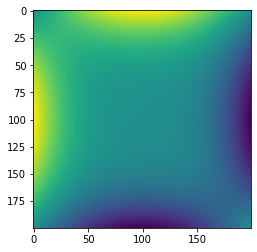

In [ ]:
%matplotlib inline
%run laplace.py --backend cython --openmp --show --nx 200 --ny 200

The same example can be run on a GPU using CUDA as follows

Number of iterations = 2243
Time taken = 0.601156 secs


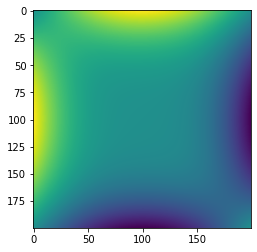

In [ ]:
%matplotlib inline
%run laplace.py --backend cuda --show --nx 200 --ny 200

Lets try to increase the number of grid points and see how the GPU backends perform as compared to CPU.

In [ ]:
%run laplace.py --openmp --nx 1000 --ny 1000
%run laplace.py --backend cuda --nx 1000 --ny 1000
%run laplace.py --backend opencl --nx 1000 --ny 1000

Number of iterations = 3687
Time taken = 36.9355 secs
Number of iterations = 3688
Time taken = 1.05824 secs
Number of iterations = 3688
Time taken = 1.83411 secs


As you can see above, the CPU backend takes 35 seconds whereas the GPU takes less than a couple of seconds.

# Molecular dynamics example

This is the example that is discussed at length in our [full paper](http://procbuild.scipy.org/download/prabhuramachandran-compyle). We look at a simulation of particles interacting via a Lennard Jones potential using a non-periodic boundary condition


In [ ]:
%cd molecular_dynamics/

/content/data/compyle/examples/molecular_dynamics


Looking at the simple $O(N^2)$ version discussed in the paper:

In [ ]:
%pycat md_simple.py

Let us run this example on the CPU using OpenMP with 50,000 particles for 20 timesteps 

In [ ]:
%run md_simple --openmp -n 50000 --tf 0.4 --dt 0.02 --suppress-warnings

Energy at time step = 0 is -36735.79626613717
Time taken for N = 50000 is 71.5315 secs


The same example can be run on the GPU using `cuda` or `opencl` backends as follows

In [ ]:
%run md_simple --backend opencl -n 50000 --tf 0.4 --dt 0.02 --suppress-warnings

Energy at time step = 0 is -36735.79269078374
Time taken for N = 50000 is 0.419632 secs


In [ ]:
%run md_simple --backend cuda -n 50000 --tf 0.4 --dt 0.02 --suppress-warnings

Energy at time step = 0 is -36735.79269078374
Time taken for N = 50000 is 0.820158 secs


On an NVIDIA Tesla P100 GPU, we see the following speedup results using the simple implementation,

<div>
<img src="https://drive.google.com/uc?id=1vS_4qZhHhN3mdNKZGOHY_4ZZtQP75zKW" width="500"/>
</div>

Next lets look at a more efficient $O(N)$ implementation using nearest neighbor searching

In [ ]:
%pycat md_nnps.py

Lets try running a simulation using a huge number of particles on the GPU.

In [ ]:
%run md_nnps --backend cuda -n 10000000 --tf 0.5 --dt 0.02 --suppress-warnings

Energy at time step = 0 is -7272470.95786804
Time taken for N = 10000000 is 1.42111 secs


In [ ]:
%run md_nnps --backend opencl -n 10000000 --tf 0.5 --dt 0.02 --suppress-warnings

Energy at time step = 0 is -7272470.95786804
Time taken for N = 10000000 is 1.24138 secs


Following are the speedup results for the $O(N)$ implementation of an NVIDIA Tesla P100 GPU

<div>
<img src="https://drive.google.com/uc?id=18odo1q42ujHC22xESssVPlDKu39ZR2bg" width="500"/>
</div>

The [examples](https://github.com/pypr/compyle/tree/master/examples/molecular_dynamics/3D) in compyle also include a 3D implementation of the molecular dynamics problem. It also includes an implementation of periodic boundary conditions. We ran a test to compare the performance of our implementation with HooMD. This was the result on an NVIDIA Tesla P100 GPU. We saw that our implementation was about 2x faster than HooMD.

<div>
<img src="https://drive.google.com/uc?id=1FAQxYRNVK3ljivW-OJ3P3--X3Z69hE53" width="500"/>
</div>
